# Model Based Machine Learning - Used Cars Price Prediction

## Imports

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline


In [53]:
"""Command to create a python file of the notebook (change path as needed):"""""
#c:\Users\cahar\AppData\Local\Programs\Python\Python311\python.exe -m jupyter nbconvert --to script model_based_ml_project.ipynb

'Command to create a python file of the notebook (change path as needed):'

# Data: Description, Preprocessing, and Analysis

In [54]:
# Loading the data and inspect the first rows
df = pd.read_csv('csv_files\car_price_prediction.csv')
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Private user\AppData\Local\Temp\ipykernel_6644\2653019209.py:2: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv('csv_files\car_price_prediction.csv')


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [55]:
# Inspect the dataset: we start with the shape of the dataset, columns, and types
print("Dataset shape: ", df.shape)
print("Columns and Types:")
print(df.dtypes)

Dataset shape:  (19237, 18)
Columns and Types:
ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object


In [56]:
#check for duplications
df.duplicated().sum()

313

In [57]:
# we will drop duplications and check for missing values
df.drop_duplicates(inplace= True)
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

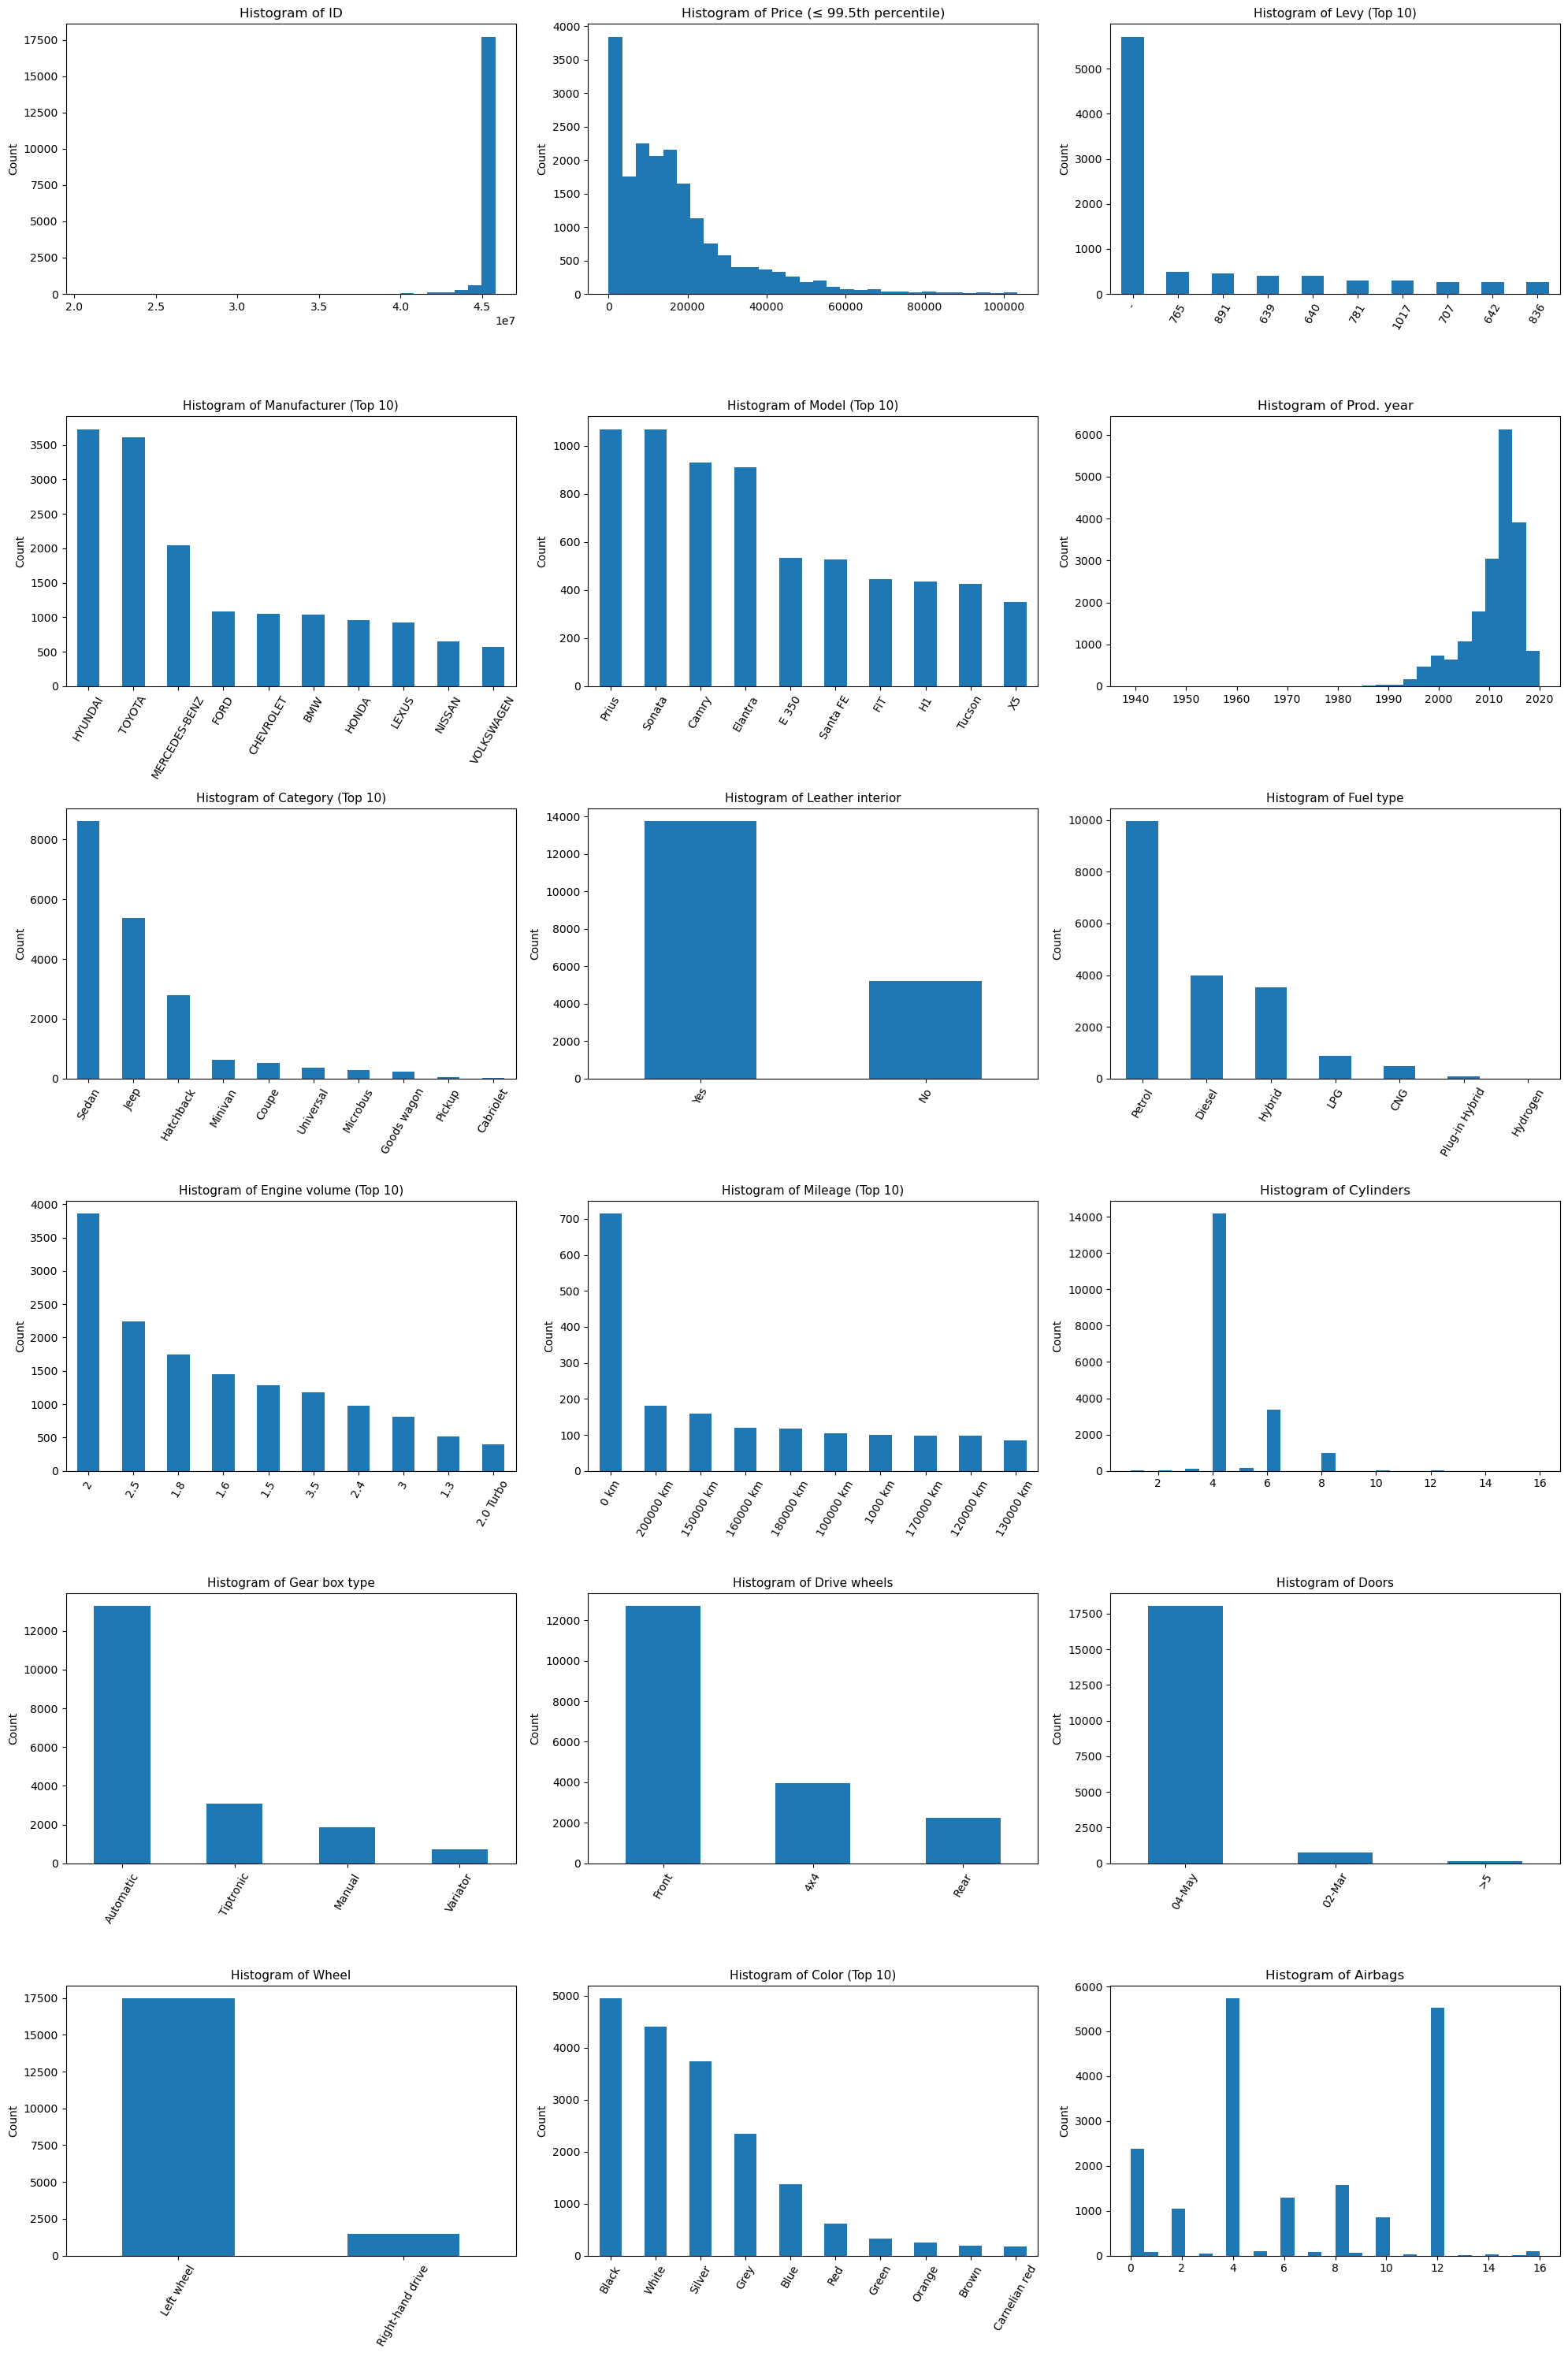

In [58]:

# Number of columns per row in the plot grid
n_cols = 3
n_rows = -(-len(df.columns) // n_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(df.columns):
    ax = axes[i]
    try:
        if col == "Price":
            price_data = df[col].astype(float)
            upper_limit = price_data.quantile(0.995)
            price_data = price_data[price_data <= upper_limit]
            price_data.plot(kind='hist', bins=30, ax=ax)
            ax.set_title(f"Histogram of {col} (≤ 99.5th percentile)")
        else:
            df[col].astype(float).plot(kind='hist', bins=30, ax=ax)
            ax.set_title(f"Histogram of {col}") 
    except:
        # For categorical data, show only the top 20 most frequent categories
        vc = df[col].value_counts(dropna=True)
        vc[:10].plot(kind='bar', ax=ax)
        ax.set_title(f"Histogram of {col} (Top 10)" if df.nunique()[col]>=10 else f"Histogram of {col}" , fontsize=11)
        ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.savefig(r'images\histograms_dataframe.png', bbox_inches='tight')
plt.show()

As expected, there are many values that need preprocessing, and we can also ignore some features that we believe that do not have influence over the price (e.g. Steering wheels side, color and ID). Other features need to be treated differently: for example, milage contains the string "KM". This should be removed and the values should contain only the numerical value. Other features such as engine volume, contain some additional information about the engine like "turbo" - which we will split into another binary feature that will contain values 0 or 1 for whether the engine is a turbo engine (0 if not, else 1). Additionally, many of the features are categorical, hence we will use one-hot encoding or ordinal encoding to fix them and fit them to a regression model.

Another desicion is to drop the attribute "model". This is due to high cardinality, as we have 1590 unique values (see the list below). Moreover, the "model" feature can be captured by other features of the car. i.e. the common sense is saying that the model is a major factor in the price, however, we believe that the rest of the features will capture the quality of a certain model (e.g. engine volume, leather seats, number of airbags etc). 

In [59]:
# Check the number of unique values of each column
df.nunique()

ID                  18924
Price                2315
Levy                  559
Manufacturer           65
Model                1590
Prod. year             54
Category               11
Leather interior        2
Fuel type               7
Engine volume         107
Mileage              7687
Cylinders              13
Gear box type           4
Drive wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

In [60]:
# Drop irrelevant columns -4 columns
df_cleaned = df.drop(columns=['ID', 'Model', 'Color', 'Wheel','Doors'])

# Levy to numeric
df_cleaned['Levy'] = df_cleaned['Levy'].replace('-', pd.NA)
df_cleaned['Levy'] = pd.to_numeric(df_cleaned['Levy'], errors='coerce')

#Leather interior to binary
df_cleaned['Leather interior'] = df_cleaned['Leather interior'].map({'Yes': 1, 'No': 0})

In [61]:
#check the unique values and additional strings in engine volume
engine_volume_values = df_cleaned['Engine volume'].unique()
sorted(engine_volume_values)

['0',
 '0.1',
 '0.2',
 '0.2 Turbo',
 '0.3',
 '0.3 Turbo',
 '0.4',
 '0.4 Turbo',
 '0.5',
 '0.6',
 '0.6 Turbo',
 '0.7',
 '0.7 Turbo',
 '0.8',
 '0.8 Turbo',
 '0.9',
 '1',
 '1.0 Turbo',
 '1.1',
 '1.1 Turbo',
 '1.2',
 '1.2 Turbo',
 '1.3',
 '1.3 Turbo',
 '1.4',
 '1.4 Turbo',
 '1.5',
 '1.5 Turbo',
 '1.6',
 '1.6 Turbo',
 '1.7',
 '1.7 Turbo',
 '1.8',
 '1.8 Turbo',
 '1.9',
 '1.9 Turbo',
 '2',
 '2.0 Turbo',
 '2.1',
 '2.1 Turbo',
 '2.2',
 '2.2 Turbo',
 '2.3',
 '2.3 Turbo',
 '2.4',
 '2.4 Turbo',
 '2.5',
 '2.5 Turbo',
 '2.6',
 '2.7',
 '2.7 Turbo',
 '2.8',
 '2.8 Turbo',
 '2.9',
 '2.9 Turbo',
 '20',
 '3',
 '3.0 Turbo',
 '3.1',
 '3.2',
 '3.2 Turbo',
 '3.3',
 '3.4',
 '3.5',
 '3.5 Turbo',
 '3.6',
 '3.6 Turbo',
 '3.7',
 '3.7 Turbo',
 '3.8',
 '3.9',
 '4',
 '4.0 Turbo',
 '4.2',
 '4.2 Turbo',
 '4.3',
 '4.4',
 '4.4 Turbo',
 '4.5',
 '4.5 Turbo',
 '4.6',
 '4.6 Turbo',
 '4.7',
 '4.7 Turbo',
 '4.8',
 '4.8 Turbo',
 '5',
 '5.0 Turbo',
 '5.2',
 '5.3',
 '5.4',
 '5.4 Turbo',
 '5.5',
 '5.5 Turbo',
 '5.6',
 '5.7',
 '5.7

In [62]:
# Create 'Turbo' binary column
df_cleaned['Turbo'] = df_cleaned['Engine volume'].str.contains('Turbo').astype(int)

# Extract numeric part of engine volume
df_cleaned['Engine volume'] = df_cleaned['Engine volume'].str.replace(' Turbo', '', regex=False).astype(float)

In [63]:
#Drop 'Fuel type'
df_cleaned = df_cleaned.drop(columns=['Fuel type'])

# Mileage - remove ' km' and convert to numeric
df_cleaned['Mileage'] = df_cleaned['Mileage'].str.replace(' km', '', regex=False).str.replace(',', '')
df_cleaned['Mileage'] = pd.to_numeric(df_cleaned['Mileage'], errors='coerce')

# Cylinders and Airbags - numeric
df_cleaned['Cylinders'] = pd.to_numeric(df_cleaned['Cylinders'], errors='coerce')
df_cleaned['Airbags'] = pd.to_numeric(df_cleaned['Airbags'], errors='coerce')

# Preprocessing production year to Age
dataset_year = 2022 #The year that the used car dataset was published.
df_cleaned['Age'] = dataset_year - df_cleaned['Prod. year']
df_cleaned = df_cleaned.drop(columns=['Prod. year'])

# Preview the cleaned dataframe
df_cleaned.head()
print(df_cleaned.columns)


Index(['Price', 'Levy', 'Manufacturer', 'Category', 'Leather interior',
       'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
       'Drive wheels', 'Airbags', 'Turbo', 'Age'],
      dtype='object')


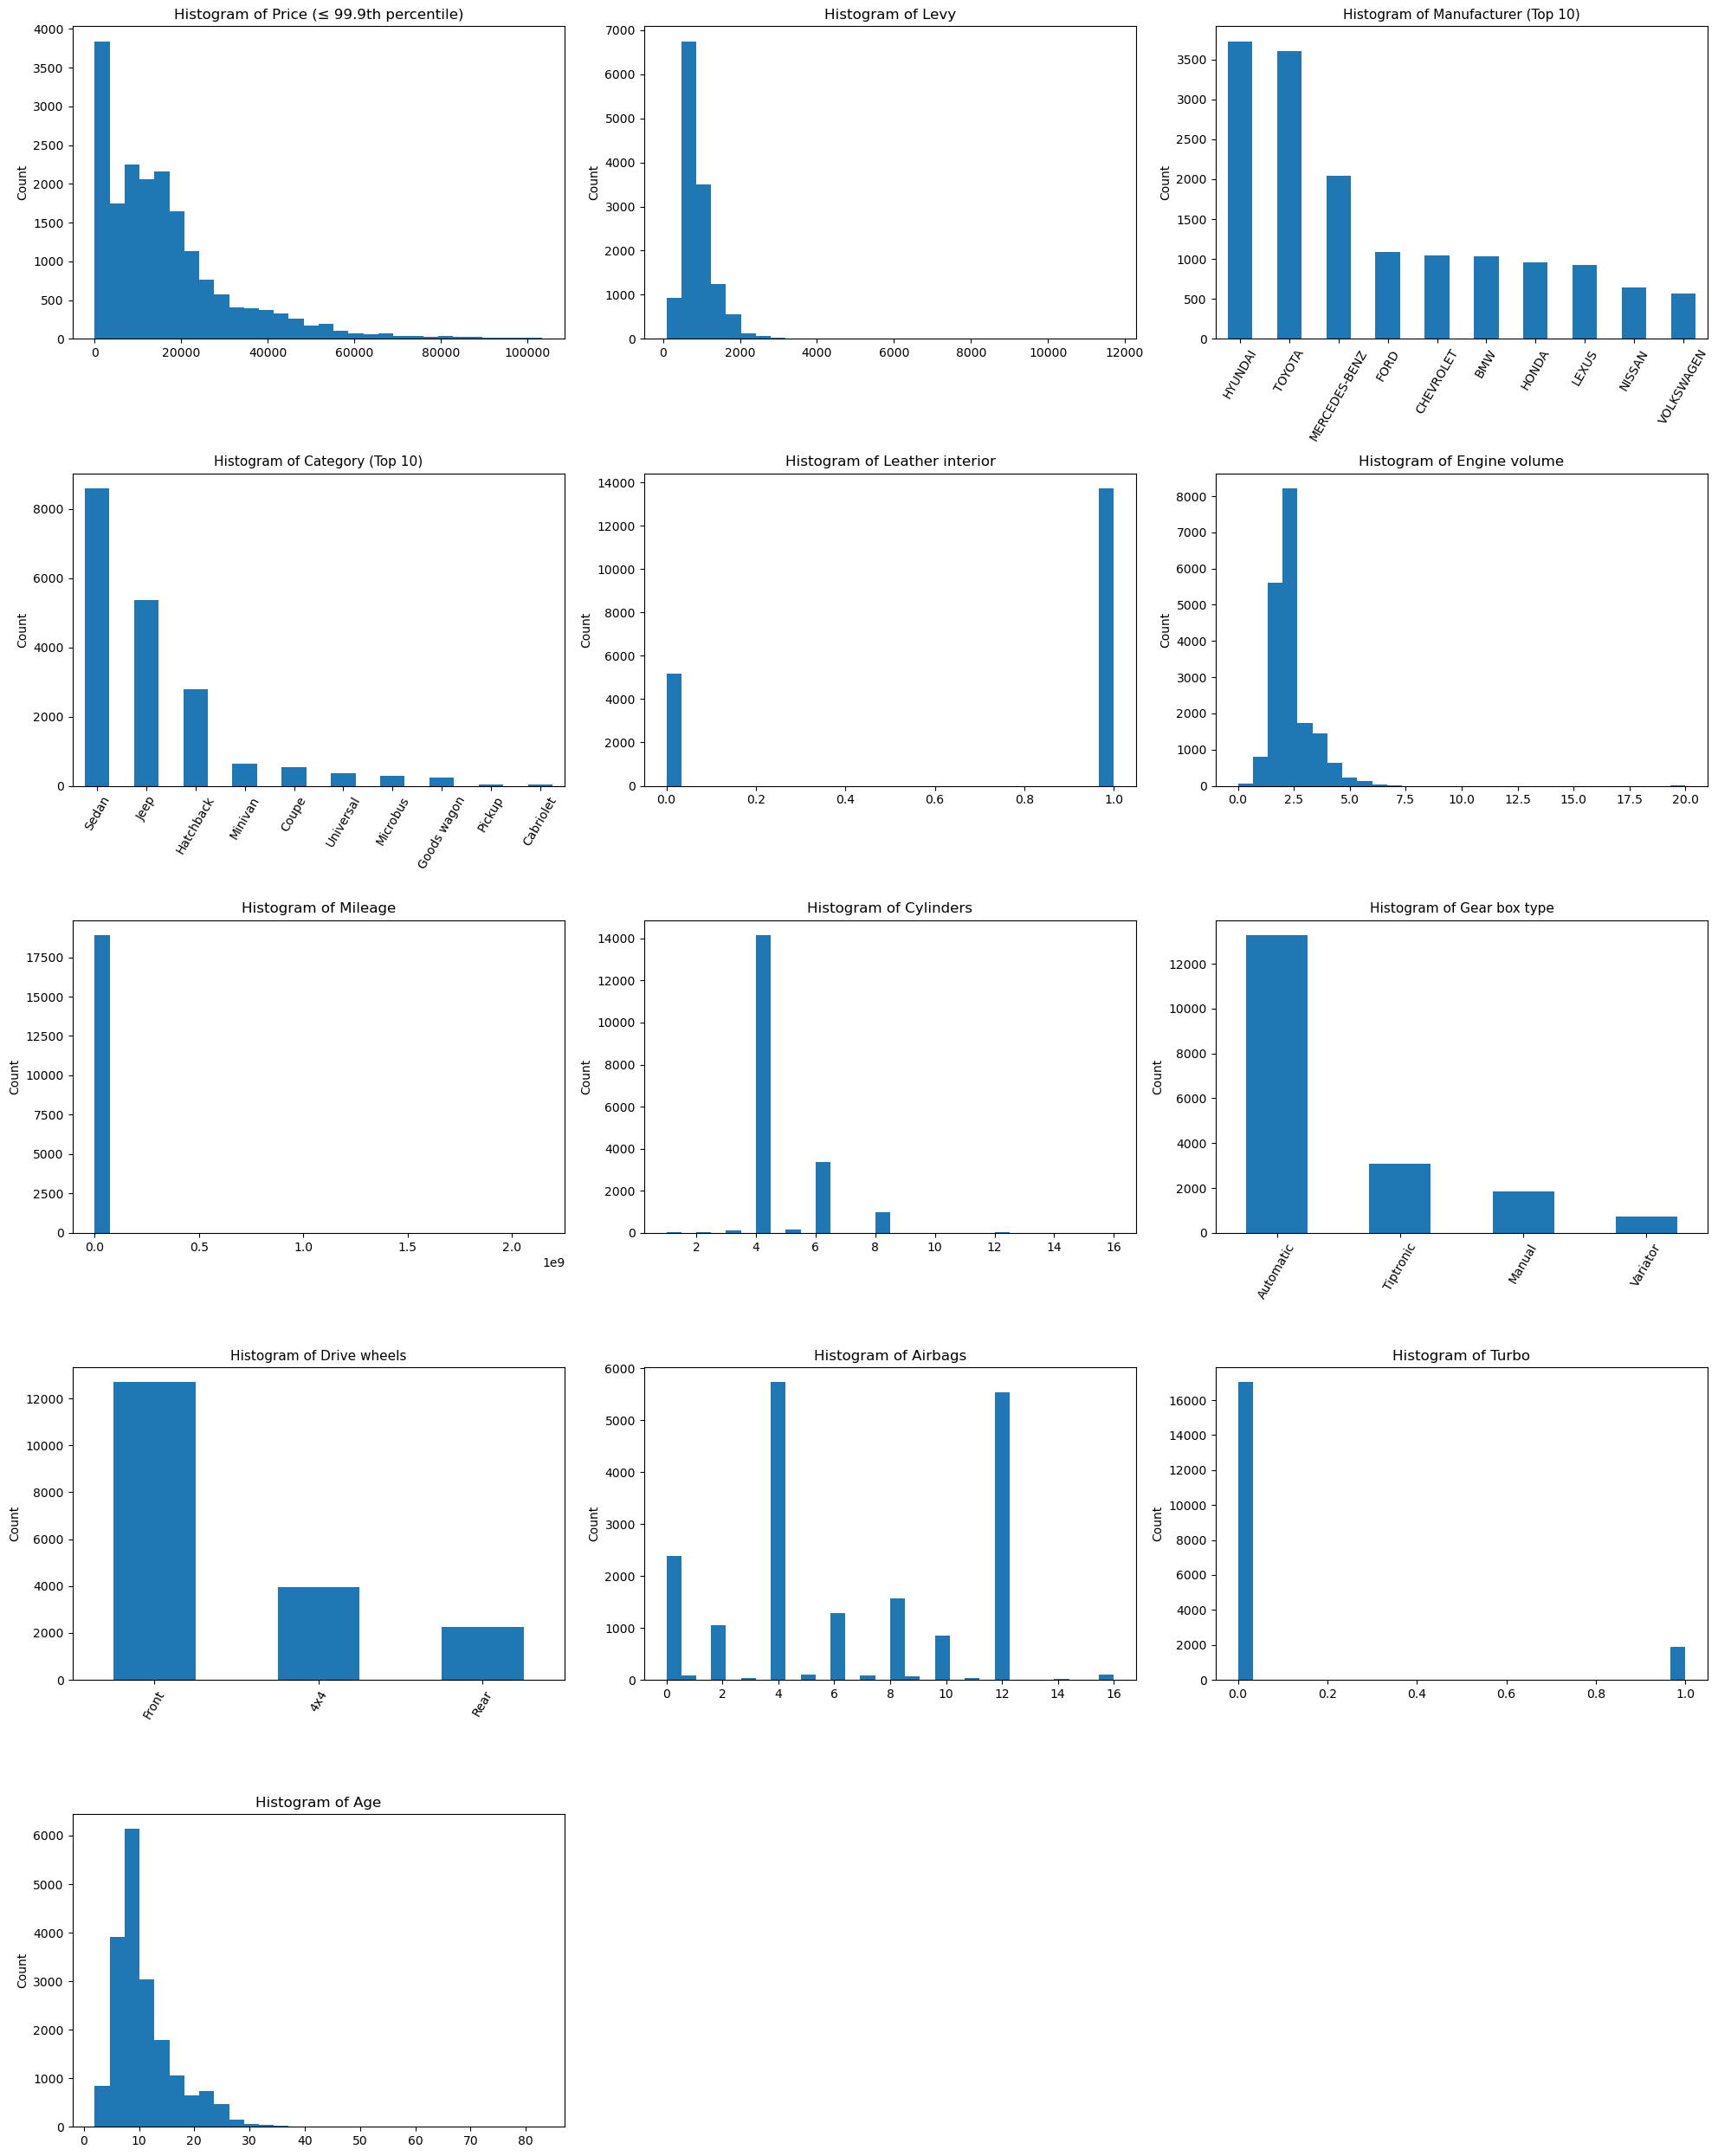

In [64]:

# Number of columns per row in the plot grid
n_cols = 3
n_rows = -(-len(df_cleaned.columns) // n_cols)  # Ceiling division

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(df_cleaned.columns):
    ax = axes[i]
    try:
        if col == "Price":
            price_data = df_cleaned[col].astype(float)
            upper_limit = price_data.quantile(0.995)
            price_data = price_data[price_data <= upper_limit]
            price_data.plot(kind='hist', bins=30, ax=ax)
            ax.set_title(f"Histogram of {col} (≤ 99.9th percentile)")
        else:
            df_cleaned[col].astype(float).plot(kind='hist', bins=30, ax=ax)
            ax.set_title(f"Histogram of {col}")
    except:
        vc = df_cleaned[col].value_counts(dropna=True)
        vc[:10].plot(kind='bar', ax=ax)
        ax.set_title(f"Histogram of {col} (Top 10)" if df_cleaned.nunique()[col] >= 10 else f"Histogram of {col}", fontsize=11)
        ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
   

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.savefig(r'images\histograms_dataframe_cleaned.png', bbox_inches='tight')
plt.show()

In [65]:
print("Descriptive Statistics:")
df_cleaned.describe().T

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Price,18924.0,1.858744e+04,1.921356e+05,1.0,5331.00,13172.0,22063.00,2.630750e+07
Levy,13215.0,9.062992e+02,4.632969e+02,87.0,640.00,781.0,1058.00,1.171400e+04
Leather interior,18924.0,7.255866e-01,4.462300e-01,0.0,0.00,1.0,1.00,1.000000e+00
Engine volume,18924.0,2.306251e+00,8.775910e-01,0.0,1.80,2.0,2.50,2.000000e+01
Mileage,18924.0,1.555373e+06,4.880221e+07,0.0,70195.75,126400.0,189119.75,2.147484e+09
Cylinders,18924.0,4.580216e+00,1.200223e+00,1.0,4.00,4.0,4.00,1.600000e+01
Airbags,18924.0,6.568379e+00,4.322323e+00,0.0,4.00,6.0,12.00,1.600000e+01
Turbo,18924.0,9.997886e-02,2.999797e-01,0.0,0.00,0.0,0.00,1.000000e+00
Age,18924.0,1.108576e+01,5.665749e+00,2.0,7.00,10.0,13.00,8.300000e+01


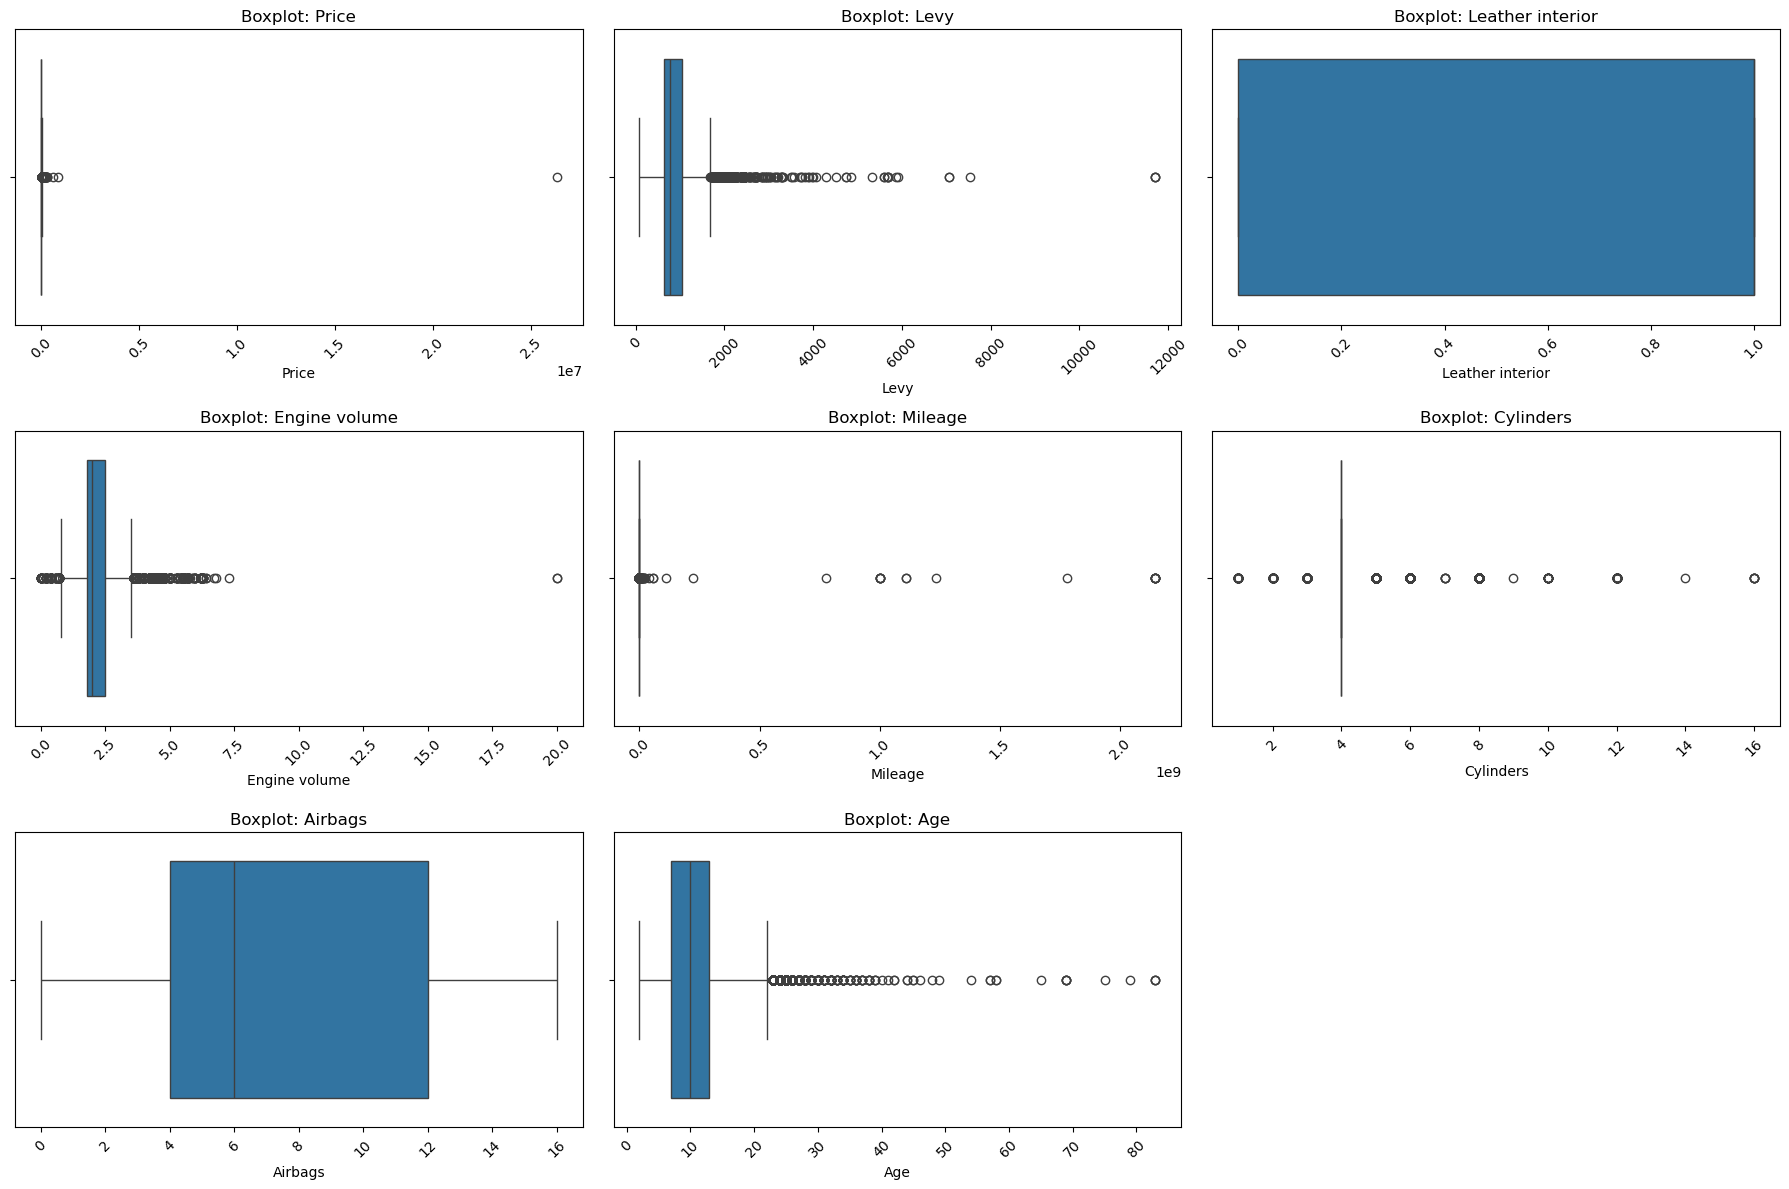

In [66]:
# Select only numerical columns
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Set up plot
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

# Create boxplot for each numeric feature
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df_cleaned, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot: {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig.savefig(r'images\boxplots.png', bbox_inches='tight')
plt.show()

It looks like the data for the price and mileage, Levy and age, got some outliers the influence the distribution. We will inspect the prices further:

In [67]:
print(df_cleaned['Price'].describe())

print(" ")

Q1 = df_cleaned['Price'].quantile(0.25)
Q3 = df_cleaned['Price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print("Upper bound:", upper_bound)

count    1.892400e+04
mean     1.858744e+04
std      1.921356e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.206300e+04
max      2.630750e+07
Name: Price, dtype: float64
 
Upper bound: 47161.0


In [68]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Price'] > 50000])}")

Number of entries: 908


In [69]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Price'] < 2000])}")

Number of entries: 3141


There are 908 records of cars that their price is greater than 50,000. Also, 3,141 cars that are priced under 2,000. We will drop them, and plot the price distribution again:

In [70]:
df_cleaned = df_cleaned[(df_cleaned['Price'] >= 2000) & (df_cleaned['Price'] <= 50000)]

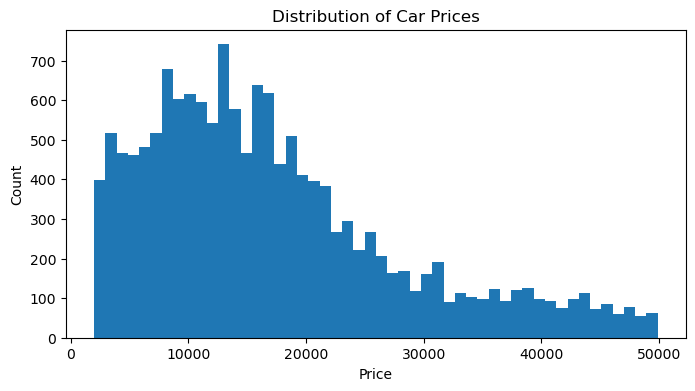

In [71]:
# Plot without those extreme prices
plt.figure(figsize=(8, 4))
plt.hist(df_cleaned['Price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution of Car Prices')
plt.show()

Due to heavy skewness of the prices, we will try to plot the distribution in it's log-values. It might help us later in the baseline model, to improve linearity between the predicted variable and the predictors.

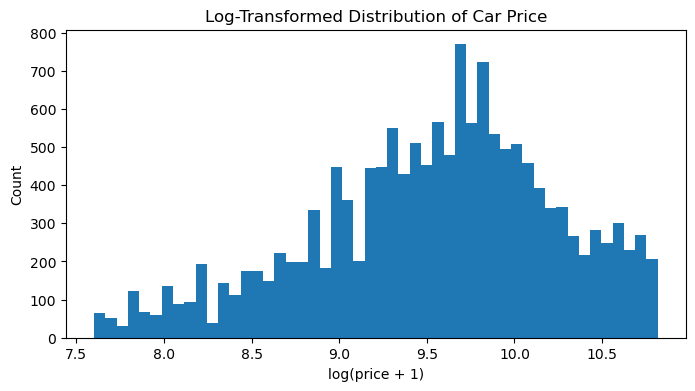

In [72]:
plt.figure(figsize=(8,4))
plt.hist(np.log1p(df_cleaned['Price']), bins=50)
plt.xlabel('log(price + 1)')
plt.ylabel('Count')
plt.title('Log-Transformed Distribution of Car Price')
plt.show()

In [73]:
#we do the same for mileage:
print(df_cleaned['Mileage'].describe())

print(" ")

Q1 = df_cleaned['Mileage'].quantile(0.25)
Q3 = df_cleaned['Mileage'].quantile(0.75)
IQR = Q3 - Q1
print("upper bound: ", Q3 + 1.5 * IQR)

count    1.487500e+04
mean     1.717180e+06
std      5.135177e+07
min      0.000000e+00
25%      7.200000e+04
50%      1.260000e+05
75%      1.840000e+05
max      2.147484e+09
Name: Mileage, dtype: float64
 
upper bound:  352000.0


since the upper bound for mileage is 352,000, we will check for removing a reasonable number of recordings, to avoid removing to much rows:

In [74]:
print(f"Number of entries: {len(df_cleaned[df_cleaned['Mileage'] > 370000])}")

Number of entries: 465


In [75]:
df_cleaned = df_cleaned[df_cleaned['Mileage'] <= 370000]


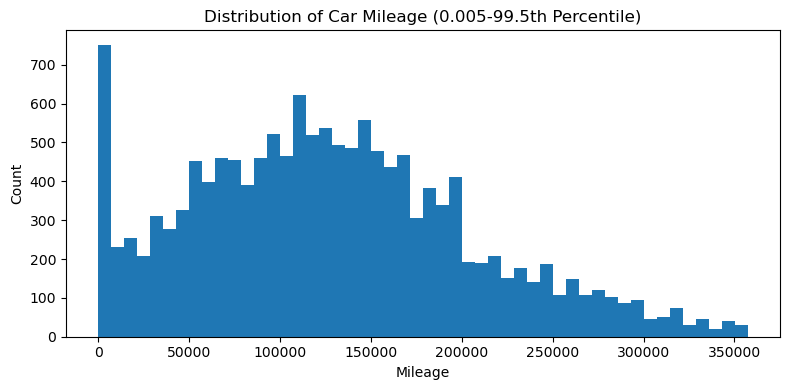

In [76]:
lower = df_cleaned['Mileage'].quantile(0.005)
upper = df_cleaned['Mileage'].quantile(0.995)

plt.figure(figsize=(8,4))
plt.hist(df_cleaned['Mileage'][(df_cleaned['Mileage'] >= lower) & (df_cleaned['Mileage'] <= upper)], bins=50)
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.title('Distribution of Car Mileage (0.005-99.5th Percentile)')
plt.tight_layout()
plt.show()


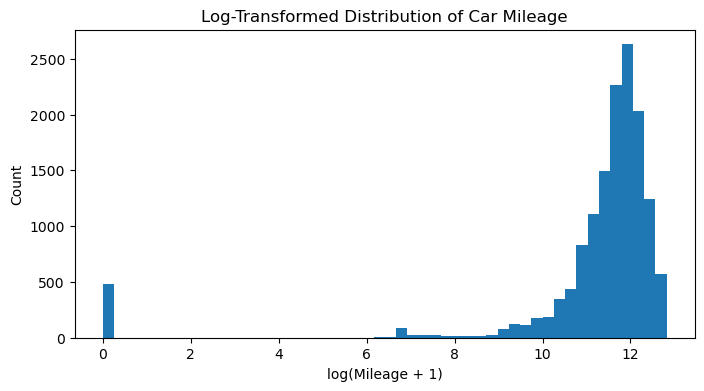

In [77]:
plt.figure(figsize=(8,4))
plt.hist(np.log1p(df_cleaned['Mileage']), bins=50)
plt.xlabel('log(Mileage + 1)')
plt.ylabel('Count')
plt.title('Log-Transformed Distribution of Car Mileage')
plt.show()

In [78]:
# another check for our features and missing values:
print("Dataset shape: ", df_cleaned.shape)
print("Columns and Types:")
print(df_cleaned.dtypes)
print(" ")
print("Missing Values:")
df_cleaned.isnull().sum()

Dataset shape:  (14410, 13)
Columns and Types:
Price                 int64
Levy                float64
Manufacturer         object
Category             object
Leather interior      int64
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type        object
Drive wheels         object
Airbags               int64
Turbo                 int32
Age                   int64
dtype: object
 
Missing Values:


Price                  0
Levy                4889
Manufacturer           0
Category               0
Leather interior       0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Airbags                0
Turbo                  0
Age                    0
dtype: int64

We can still see some missing values for the Levy. Levy generally refers to a tax or fee imposed by the government based on characteristics of the vehicle. Levy is influenced by the cars features like engine volume, age, vehicle type etc. We will impute missing data for levy based on engine volume and category - we will find the median value for engine volume and category and fill the missing levy based on this value.

In [79]:
group_medians = df_cleaned.groupby(['Engine volume', 'Category'])['Levy'].median()
group_medians.isnull().sum()

91

In [80]:
#Since there are some in group_median that are NaN, 
# we will create another group, a more general group_medians, this time by engine volume only:
engine_volume_medians = df_cleaned.groupby('Engine volume')['Levy'].median()
print("Number of engine_volume_medians NaNs: ", engine_volume_medians.isnull().sum())

# There are still NaNs, hence we will create a global median for the rest
global_median_levy = df_cleaned['Levy'].median()

Number of engine_volume_medians NaNs:  8


In [81]:
def impute_levy(row):
    if pd.isnull(row['Levy']):
        key = (row['Engine volume'], row['Category']) # first group_median
        levy_value = group_medians.get(key, np.nan)
        
        if pd.isnull(levy_value):  # If group_median not found, use engine_volume_medians
            levy_value = engine_volume_medians.get(row['Engine volume'], np.nan)
            
        if pd.isnull(levy_value):  # If not found, use global_median_levy
            levy_value = global_median_levy
            
        return levy_value
    return row['Levy']

In [82]:
# applying the imputation
# we will use the "regular" imputation for df_baseline, 
# because maybe later we will use different approach for imputation
df_cleaned['Levy'] = df_cleaned.apply(impute_levy, axis=1)

In [83]:
# Checking again for missing values after the data cleansing
df_cleaned.isnull().sum()

Price               0
Levy                0
Manufacturer        0
Category            0
Leather interior    0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Airbags             0
Turbo               0
Age                 0
dtype: int64

Now it looks like we are done with the missing values. We will proceed with outliers clean up:

In [84]:
columns_to_check = ['Levy', 'Engine volume', 'Airbags', 'Cylinders', 'Age']

for col in columns_to_check:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)).sum()
    total = df_cleaned[col].shape[0]
    
    print(f"{col}: {outliers} outliers ({round(100 * outliers / total, 2)}%) — bounds: [{lower_bound:.1f}, {upper_bound:.1f}]")

Levy: 849 outliers (5.89%) — bounds: [49.5, 1621.5]
Engine volume: 600 outliers (4.16%) — bounds: [0.3, 3.8]
Airbags: 0 outliers (0.0%) — bounds: [-5.0, 19.0]
Cylinders: 3139 outliers (21.78%) — bounds: [4.0, 4.0]
Age: 643 outliers (4.46%) — bounds: [-1.0, 23.0]


It doesn't look like much outliers. We can remove them, except Cylinders, that we will clean a certain and logical range:

In [85]:
df_cleaned = df_cleaned[df_cleaned['Levy'] <= 1584]
df_cleaned = df_cleaned[df_cleaned['Engine volume'] <= 3.8]
df_cleaned = df_cleaned[(df_cleaned['Cylinders'] >= 2) & (df_cleaned['Cylinders'] <= 12)]
df_cleaned = df_cleaned[(df_cleaned['Age'] >= 2) & (df_cleaned['Age'] <= 26)]

In [86]:
df_baseline = df_cleaned.copy()

We still have some features remained to encode:

* **Manufacturer** - Since we believe that there is a strong correlation between the brand and the price, we will encode this by ranking the average price per manufacturer. This captures the average value impact of each manufacturer on price, which makes intuitive sense (e.g. Mercedes vs. Hyundai). It will also will help us to reduce cardinality to a single numeric column, unlike one-hot encoding. However, we're familiar with this problematic feature transformation since we are encoding the target variable. Instead of assigning each manufacturer a unique rank, we will group them into price-based ranges that will hopefully prevent over-fitting and reduces sensitivity to small price differences between manufacturers.
* **Category** - We will check whether to use dummy variables or ordinal values.
* **Gear-Box Type** - We will check whether to use dummy variables or ordinal values.
* **Drive Wheels** - We will check whether to use dummy variables or ordinal values.

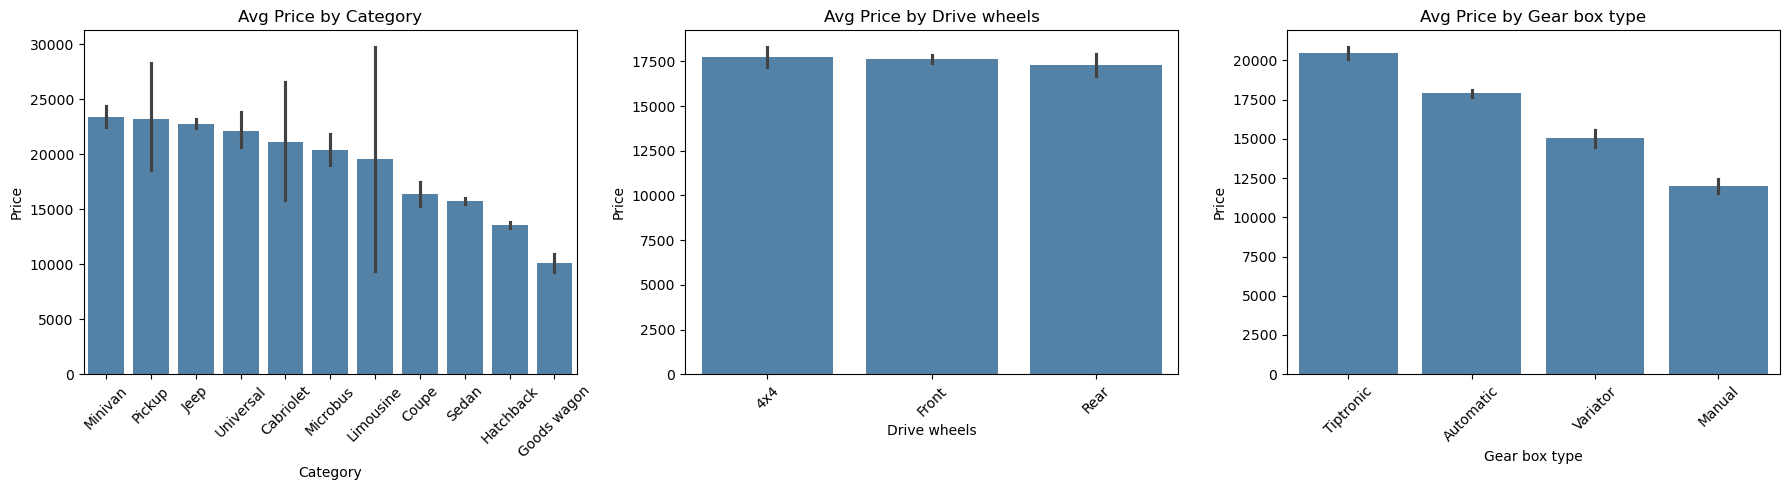

In [87]:
# before proceeding to the last 3 variables, we'll check if there is some correlation between the price
# and those variable. If there is, we would prefer to transform them into a ordinal variable
# rather than one-hot encoding

avg_price_by_category = df_baseline.groupby('Category')['Price'].mean().sort_values(ascending=False)
avg_price_by_gear = df_baseline.groupby('Gear box type')['Price'].mean().sort_values(ascending=False)
avg_price_by_Drive_wheels = df_baseline.groupby('Drive wheels')['Price'].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

sns.barplot(x='Category', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_category.index, ax=axes[0])
axes[0].set_title('Avg Price by Category')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='Drive wheels', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_Drive_wheels.index, ax=axes[1])
axes[1].set_title('Avg Price by Drive wheels')
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x='Gear box type', y='Price', data=df_baseline, color='steelblue', order=avg_price_by_gear.index, ax=axes[2])
axes[2].set_title('Avg Price by Gear box type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
fig.savefig(r'images\categorical_vars.png', bbox_inches='tight')
plt.show()

The three bar plots above show the average car price for each category within the variables Category, Gear box type, and Drive wheels. These plots reveal the patterns in how these features relate to the target variable (Price):

* Category: There is a clear ranking among vehicle types. High-priced categories like Pickup, Cabriolet, and jeep, consistently outperform lower-end types like Goods wagon and Hatchback.

* Gear box type: Average prices decrease consistently from Tiptronic to Manual, indicating a strong ordinal relationship. This also corresponds to common knowledge that e.g. automatic car is more expenssive than manual car.

* Drive wheels: Since differences are smaller, we will use one-hot encoding.

Given these ordered relationships with price, it's appropriate to encode these Category and Gear box type variables as ordinal values, rather than one-hot encoding. For Drive wheels we will use one-hot encoding since the price differences are not that significant. This approach reduces dimensionality while preserving the underlying value hierarchy these features represent.

In [88]:
# Rank encoding for Category
avg_price_by_category = df_baseline.groupby('Category')['Price'].mean().sort_values()
category_rank = avg_price_by_category.rank(method='first').astype(int)
df_baseline['Category_encoded'] = df_baseline['Category'].map(category_rank)

# Rank encoding for Gear box type
avg_price_by_gear = df_baseline.groupby('Gear box type')['Price'].mean().sort_values()
gearbox_rank = avg_price_by_gear.rank(method='first').astype(int)
df_baseline['GearBox_encoded'] = df_baseline['Gear box type'].map(gearbox_rank)

# One-hot encoding for Drive wheels
drive_dummies = pd.get_dummies(df_baseline['Drive wheels'], prefix='Drive')
df_baseline = pd.concat([df_baseline, drive_dummies], axis=1)

We will check correlations again, now that the data is fully ready:

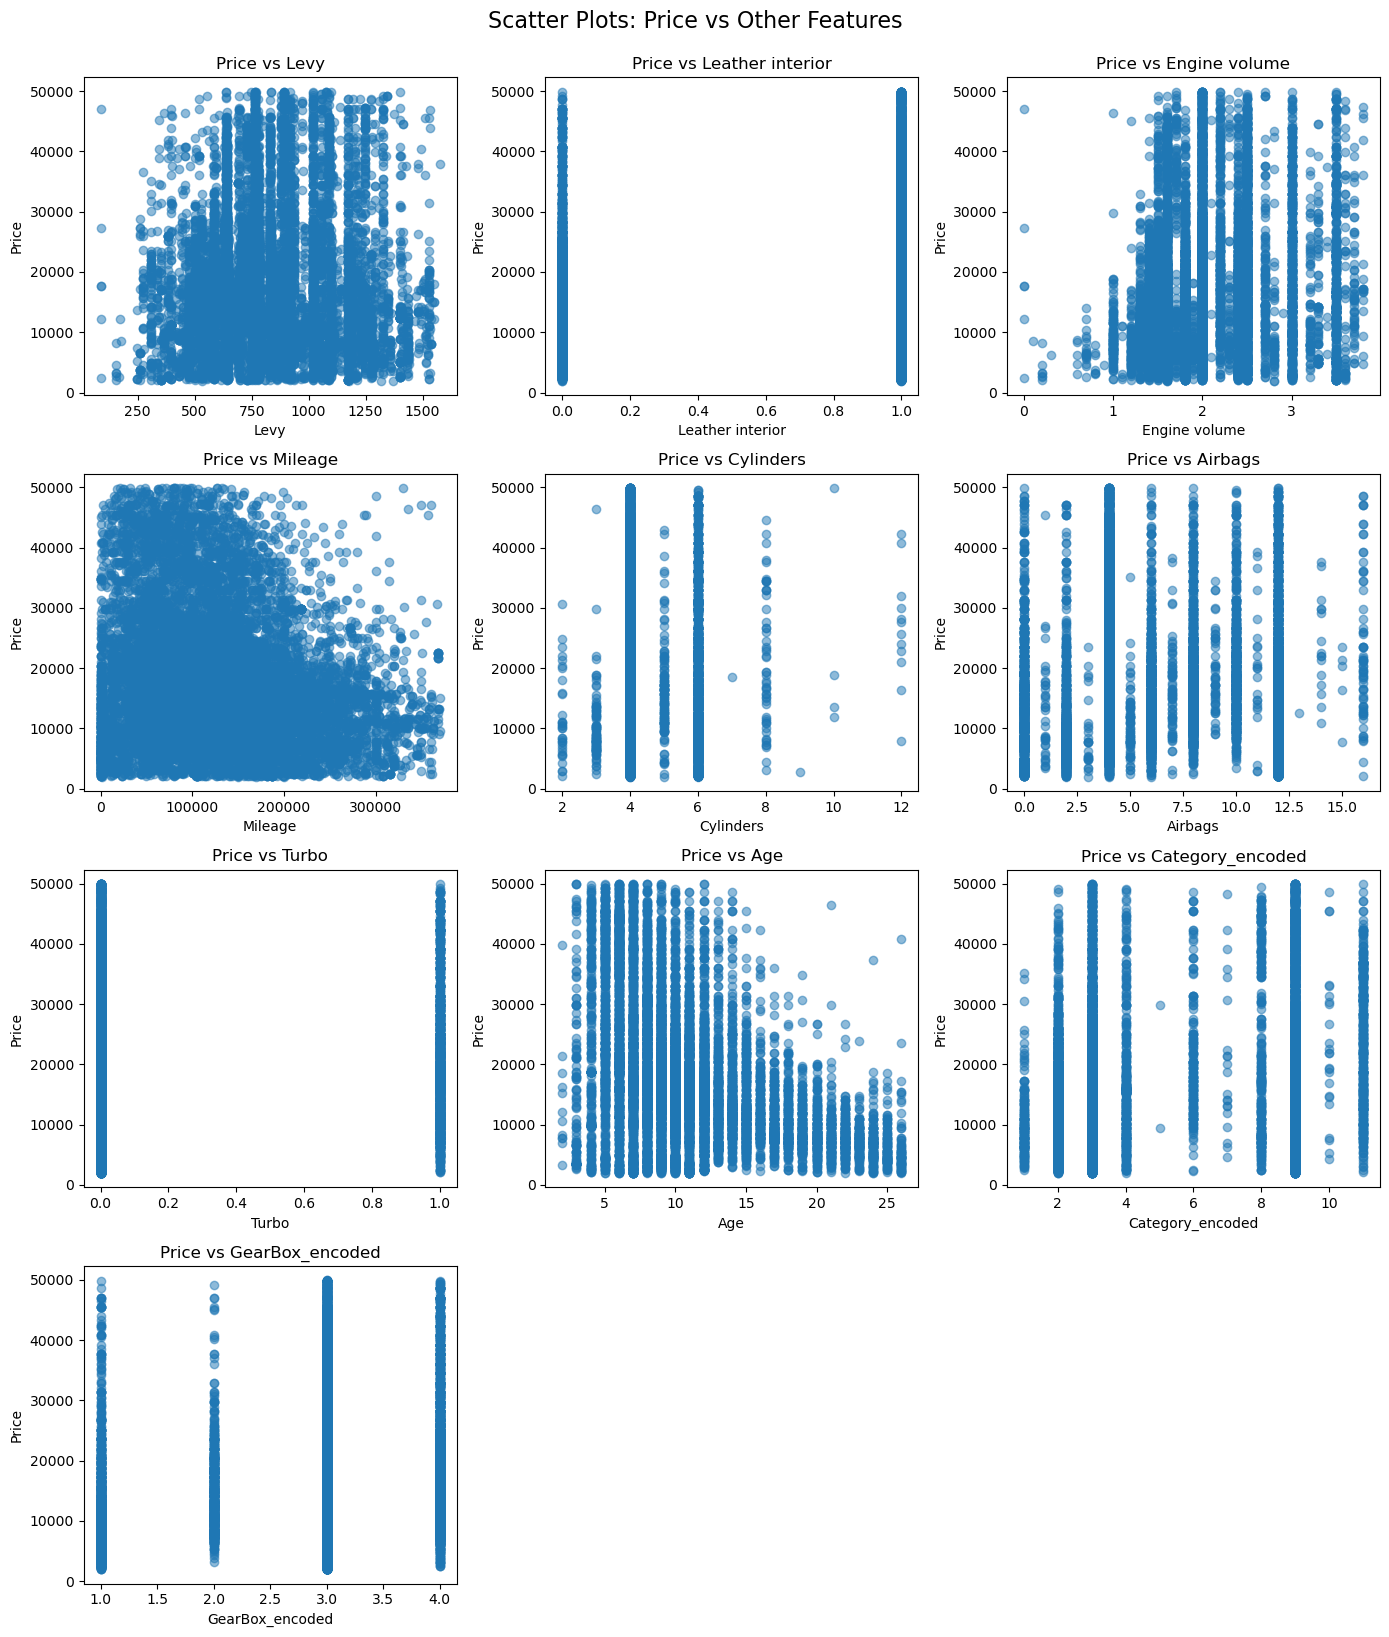

In [89]:
numeric_cols = df_baseline.select_dtypes(include=['float64', 'int64', 'int32','int64']).columns
features_to_plot = [col for col in numeric_cols if col != 'Price']

n_cols = 3
n_rows = -(-len(features_to_plot) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    ax = axes[i]
    ax.scatter(df_baseline[col], df_baseline['Price'], alpha=0.5)
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    ax.set_title(f'Price vs {col}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Scatter Plots: Price vs Other Features', fontsize=16, y=1.02)
fig.savefig(r'images\correlation_plots.png', bbox_inches='tight')
plt.show()

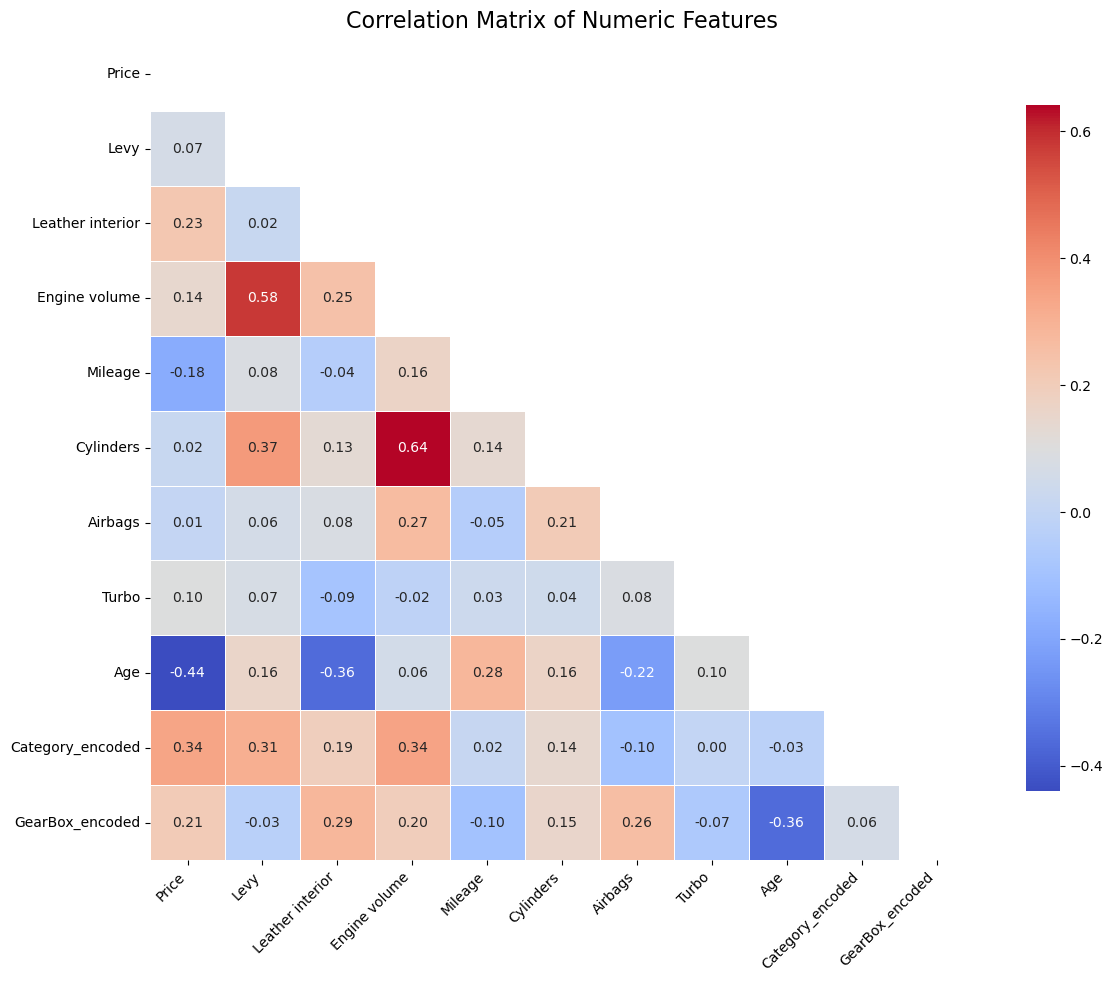

In [90]:
numeric_data = df_baseline.select_dtypes(include=[np.number])

corr = numeric_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(12, 10))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True,
    annot_kws={"size": 10},)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.tight_layout()
fig.savefig(r'images\correlation_heat_plot.png', bbox_inches='tight')
plt.show()

#### Key insights:

* Price is negatively correlated with Age (-0.42). As expected, older cars tend to be significantly cheaper.

* Manufacturer and Category encodings show moderate correlation with Price. Manufacturer_encoded (-0.38) and Category_encoded (0.34) suggest your rank-based encoding reflects meaningful pricing tiers.

* Engine volume and Cylinders are strongly correlated (0.64). This is logical, as bigger engines usually have more cylinders.

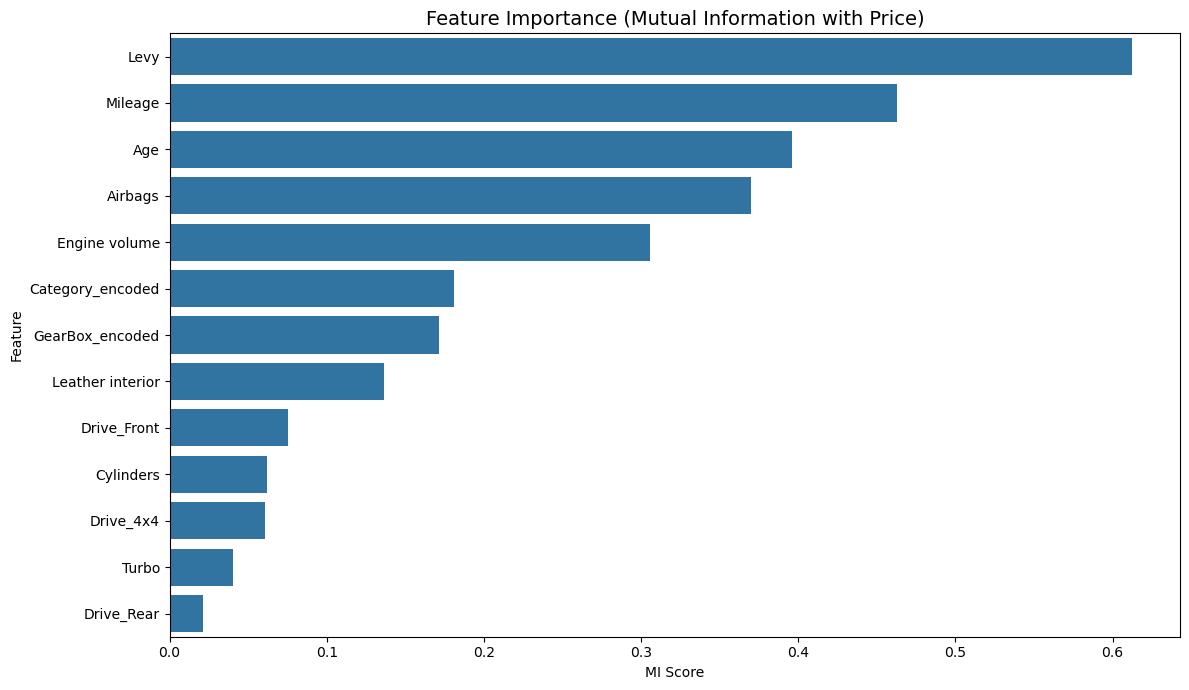

In [91]:
# Define features and target
X = df_baseline.drop(columns=[
    'Price',                # target
    'Manufacturer',         # original categorical
    'Category',
    'Gear box type',
    'Drive wheels'          # now one-hot encoded
])
y = df_baseline.loc[X.index, 'Price']  # Align y with X

# Compute mutual information
mi_scores = mutual_info_regression(X, y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Feature Importance (Mutual Information with Price)", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Key Insights

The above chart shows feature importance using a method called Mutual Information (MI). It's a way of measuring how much each feature in the dataset tells us about the target variable. Mutual Information measures how much knowing the value of one variable reduces uncertainty about another (e.g. mileage and price). It captures any kind of relationship, linear or nonlinear, unlike correlation which only captures linear relationships.

In our case, it looks like mileage, Levy, airbags, and age are prominent in predicting the price, as they got a higer MI score. i.e. newer cars with more airbags and bigger engines tend to be pricier. Manufacturer_encoded, and Category_encoded matter, but to a lesser degree.

### Data Preprocessing Summary

Before building a regression model, several steps were taken to clean and prepare the data:

* Dropped unnecessary columns: Features like ID, Color, Model, and Steering Wheel Side were removed because they either had too many unique values, were unlikely to influence price directly, or were redundant.

* Fixed data formatting issues: Some columns had text mixed with numbers (e.g. "km" in mileage or "Turbo" in engine volume). These were cleaned so that only numerical values remained. For instance, we also created a new column to indicate whether a car had a turbo engine.

* Converted categorical variables: Categorical features (like Leather Interior) were converted to numerical form to work with machine learning models.

* Handled missing and invalid values: Placeholder values like "-" were replaced with actual missing values (NaN) and converted to proper numerical types.

* Created a new feature for car age: Instead of using the production year directly, we calculated the car's age by subtracting the production year from the current year.

* Removed outliers: Extremely high values for price and mileage were removed because they could distort the results of the model. The cutoffs were based on distribution analysis using boxplots and interquartile range (IQR).

* Applied log transformation: Car prices and mileage were both highly skewed. Applying a logarithmic transformation helps to reduce skewness and may improve model performance by making the data more normally distributed.

* Handling Levy missing values - we created a few base groups that Levy is influenced by (engine volume, and category, engine volume, and general) and applied imputation using the median of those groups.

* Handling manufacturer, Category, and Gear box type: we turned those variables into ordinal variables based on their pattern with the price. The pattern also corresponded with believes and knowledge - for instance, a manual car is cheaper than automatic car (for gear box). for Drive wheels we decided to keep the one-hot encoding due to the insignificant prices between the 3. For the manufacturer feature, we believe that there is a strong correlation between the brand and the price. Hence, we groupped the average price by manufacturer, this captures the average value impact of each manufacturer on price, which makes intuitive sense (e.g. Mercedes vs. Hyundai). While keeping in mind this problematic feature transformation we splitted the brands into bins based on average price ranges to prevent over-fitting.

Now that we are done analyzing and processing the data, we can save it to a .csv file.

In [92]:
#Save the df_baseline to a .csv file
df_baseline.to_csv("csv_files\df_baseline.csv", index=False)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Private user\AppData\Local\Temp\ipykernel_6644\3053873422.py:2: SyntaxWarning: invalid escape sequence '\d'
  df_baseline.to_csv("csv_files\df_baseline.csv", index=False)


# Gaussian Process with ARD
This section implements a Variational Sparse Gaussian Process (GP) with Automatic Relevance Determination (ARD) to predict used car prices, using an RBF kernel and sparse inducing points. We train the model, evaluate on a test set, visualize predictions, and analyze feature relevance via ARD lengthscales.

In [93]:
# Additional imports for Gaussian Process
import torch
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Clear Pyro parameter store to avoid conflicts
pyro.clear_param_store()

Data Preparation (Train-Test Split, Standardization)

In [100]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure df is available (assumes it’s loaded and preprocessed from earlier cells)
if 'df' not in globals():
    try:
        df = pd.read_csv('csv_files/car_price_prediction.csv')
    except FileNotFoundError:
        print("car_price_prediction.csv not found.")
        raise

# Print columns for debugging
print("Available columns in DataFrame:", df.columns.tolist())

# Define features and target (aligned with GP.py)
feature_cols = [
    'Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags',
    'Turbo', 'Age',
    'Manufacturer_encoded', 'Category_encoded', 'GearBox_encoded',
    'Drive_4x4', 'Drive_Front', 'Drive_Rear'
]
target_col = 'Price'

# Add Manufacturer encoding if not present (based on preprocessing summary)
if 'Manufacturer_encoded' not in df.columns:
    mean_prices = df.groupby('Manufacturer')['Price'].mean().sort_values()
    ordinal_map = {val: idx for idx, val in enumerate(mean_prices.index)}
    df['Manufacturer_encoded'] = df['Manufacturer'].map(ordinal_map)

# Verify all feature columns exist
missing_cols = [col for col in feature_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Columns {missing_cols} not found in DataFrame")

# Clean and prepare features (ensure numeric)
for col in feature_cols:
    if df[col].dtype == object:  # Only process object-type columns
        df[col] = pd.to_numeric(df[col].replace({'True': 1, 'False': 0}), errors='coerce')
    # If already numeric (e.g., 'Mileage' cleaned earlier), no action needed

# Drop rows with NaN in features or target
df = df.dropna(subset=feature_cols + [target_col])

# Validate positive prices for log-transformation
if not (df[target_col] > 0).all():
    raise ValueError("Price contains zero or negative values, invalid for log-transformation")

# Log-transform and standardize the target
log_price = np.log(df[target_col].values.astype(float)).reshape(-1, 1)
log_price_scaler = StandardScaler()
y_log_scaled = log_price_scaler.fit_transform(log_price).flatten()

# Standardize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

# Train-test split (80-20, matching typical ML practice and GP.py’s preprocessing)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_log_scaled, test_size=0.2, random_state=42
)

# Convert to tensors for GP model
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print("Data preparation complete:")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

Available columns in DataFrame: ['Price', 'Levy', 'Manufacturer', 'Category', 'Leather interior', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Airbags', 'Turbo', 'Age', 'Category_encoded', 'GearBox_encoded', 'Drive_4x4', 'Drive_Front', 'Drive_Rear', 'Manufacturer_encoded', 'Gear box type_encoded']
Data preparation complete:
X_train_tensor shape: torch.Size([10428, 13])
X_test_tensor shape: torch.Size([2608, 13])
y_train_tensor shape: torch.Size([10428])
y_test_tensor shape: torch.Size([2608])


GP Model Setup

In [101]:

# Clear Pyro parameter store to avoid conflicts
pyro.clear_param_store()

# Define input dimension (number of features from Cell 3)
input_dim = X_train_tensor.shape[1]

# Set up RBF kernel with ARD
kernel = gp.kernels.RBF(input_dim=input_dim)

# Set priors for kernel parameters
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))  # Variance prior
kernel.lengthscale = pyro.nn.PyroSample(
    dist.LogNormal(0.0, 1.0).expand([input_dim]).to_event(1)
)  # ARD lengthscales prior

# Define Gaussian likelihood with noise prior
likelihood = gp.likelihoods.Gaussian()
likelihood.variance = pyro.nn.PyroSample(dist.HalfNormal(1.0))  # Noise prior

# Select inducing points using KMeans (M=300 for computational efficiency)
M = 300
try:
    kmeans = KMeans(n_clusters=M, random_state=42).fit(X_train_tensor.numpy())
    Xu = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
except Exception as e:
    raise ValueError(f"KMeans clustering for inducing points failed: {e}")

# Initialize Variational Sparse GP model
vsgp = gp.models.VariationalSparseGP(
    X=X_train_tensor,
    y=y_train_tensor,
    kernel=kernel,
    Xu=Xu,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-6  # Reduced jitter for numerical stability
)

print(f"GP model initialized with {input_dim} input dimensions and {M} inducing points.")

c:\Users\Private user\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Private user\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


GP model initialized with 13 input dimensions and 300 inducing points.


Model Training

c:\Users\Private user\anaconda3\Lib\site-packages\pyro\infer\trace_mean_field_elbo.py:38: UserWarning: Failed to verify mean field restriction on the guide. To eliminate this warning, ensure model and guide sites occur in the same order.
Model sites:
  kernel.lengthscale
  kernel.variance
  u
  likelihood.varianceGuide sites:
  kernel.variance
  kernel.lengthscale
  likelihood.variance
  u
  warnings.warn(


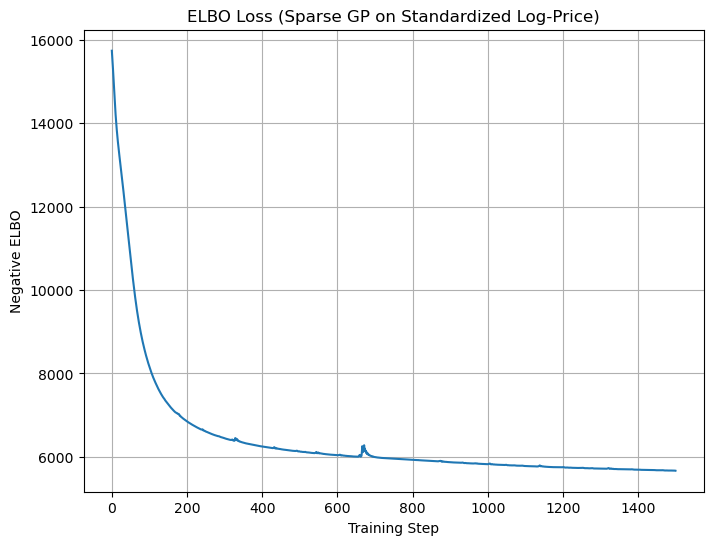

In [103]:
import matplotlib.pyplot as plt
from pyro.contrib.gp.util import train  # Import the training utility from Pyro

# Train the GP model using variational inference (full dataset)
losses = train(
    vsgp,                    # The VariationalSparseGP model from Cell 4
    num_steps=1500          # Number of training iterations
)

# Plot the ELBO loss to visualize convergence
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.title("ELBO Loss (Sparse GP on Standardized Log-Price)")
plt.xlabel("Training Step")
plt.ylabel("Negative ELBO")
plt.grid(True)
plt.show()